<a href="https://colab.research.google.com/github/Ananthzeke/Optimization-techniques/blob/main/TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TSP


In [1]:
import numpy as np
import networkx as nx
import pandas as pd

In [2]:
def generate_random_weighted_graph(n,low,high):
    g = nx.generators.complete_graph(n)
    # add random weights to the graph
    g.add_weighted_edges_from([(a,b,np.random.randint(low,high)) for a,b in g.edges()])
    return g


In [3]:
np.random.seed(3)
g = generate_random_weighted_graph(7,1,20)


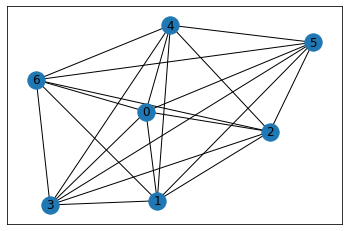

In [4]:
nx.draw_networkx(g)

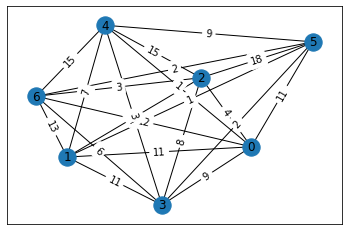

In [18]:
import matplotlib.pyplot as plt
pos=nx.spring_layout(g) 
nx.draw_networkx(g,pos)
labels = nx.get_edge_attributes(g,'weight')
nx.draw_networkx_edge_labels(g,pos,edge_labels=labels)
plt.show()

### Intialization

#### Nearest Neighbour Initialization
  - Intialize $i = 1$
  - Randomly select a node
  - Find the node  closest to $n(i)$ that has not yet been assigned to an element of $n$ and assign it to $n(i+1)$
  - $i=i+1$
  - If $i==n$:
    - terminate 
  - else:
    - Go to Step 3

In [15]:
def nearest_neighbour_initialization(g,closed_tour=False):
    curr_node = np.random.choice(g.nodes) 
    path = [curr_node]
    not_visited = set(g.nodes)-{curr_node}
    while not_visited:
        not_visited_neighbours = not_visited&set(g.neighbors(curr_node))
        key =lambda x: g[curr_node][x]["weight"]
        curr_node = min(not_visited_neighbours,key = key) 
        path.append(curr_node)
        not_visited.remove(curr_node)
    if closed_tour:
        path.append(path[0])
    return path

In [16]:
nearest_neighbour_initialization(g)

[5, 1, 4, 0, 2, 6, 3]

#### Shortest edge intialization

In [17]:
from collections import defaultdict

In [18]:
def has_cycle(g):
    try:
        nx.find_cycle(g)
    except nx.NetworkXNoCycle:
        return False
    return True

def get_path_from_edges(edges,closed_tour=False):
    path_graph = nx.Graph(edges)
    # if it is an open tour start from a node with a single degree
    curr = min(path_graph.nodes,key=path_graph.degree) 
    path,visited = [curr],{curr}
    while len(path)<len(path_graph):
        curr = (set(path_graph.neighbors(curr))-visited).pop()
        visited.add(curr)
        path.append(curr)
    if closed_tour:
        path.append(path[0])
    return path

In [19]:
def shortest_edge_initialization(g,method="greedy", closed_tour = False):
    edge_list = set(g.edges)
    times_visited  = defaultdict(int)
    tour = set() 
    max_tour_len = len(g) if closed_tour else len(g)-1
    key = nx.get_edge_attributes(g,"weight").get
    while len(tour)<max_tour_len:
       u,v = min(edge_list, key=key)
       times_visited[u]+=1
       times_visited[v]+=1
       tour.add((u,v))
       edge_list.remove((u,v))
       for u,v in set(edge_list):
            if (
                (has_cycle(nx.Graph(tour|{(u,v)})) and len(tour) != len(g)-1)
                or times_visited[u] ==2 or times_visited[v] ==2

            ):
                edge_list.remove((u,v))

    return get_path_from_edges(tour,closed_tour=closed_tour)

In [20]:
shortest_edge_initialization(g)

[1, 5, 6, 2, 0, 4, 3]

### Cross over

#### Partially Matched Crossover

In [23]:
def partially_matched_crossover(p1,p2):
    pt = np.random.randint(1,len(p1)-1) # crossover point
    c1 = p1[:pt] + p2[pt:]
    c2 = p2[:pt] + p1[pt:]
    m1=set(p1)-set(c1)
    m2=set(p2)-set(c2)
    
    if m1 or m2:
        c1=pd.Series(c1)
        c1[c1.duplicated()]=list(m1)
        c2=pd.Series(c2)
        c2[c2.duplicated()]=list(m2)
        c1=c1.to_list()
        c2=c2.to_list()
        
    return c1,c2

In [25]:
parents=[[1, 2, 0, 4, 6, 5, 3], [0, 1, 4, 2, 6, 5, 3]]
print(partially_matched_crossover(*parents))

([1, 2, 0, 4, 6, 5, 3], [0, 1, 4, 2, 6, 5, 3])


#### Order Crossover

In [37]:
def order_crossover(p1,p2):
    start = np.random.randint(0,len(p1)-1)
    end = np.random.randint(start+1,len(p1) if start !=0 else len(p1)-1)
    def fill_blanks(p1,p2,s,e):
        
        unvisited_nodes = p2.copy()
        for node in p1[s:e]:
            unvisited_nodes.remove(node)

        c = p1.copy()
        for i in range(len(p1)):
            if i<s or i>=e:
                c[i] = unvisited_nodes.pop(0)
        return c

    c1 = fill_blanks(p1,p2,start,end)
    c2 = fill_blanks(p2,p1,start,end)
    return c1,c2

In [35]:
order_crossover(*parents)

([1, 2, 0, 4, 6, 5, 3], [0, 1, 4, 2, 6, 5, 3])

### Mutation

#### Inversion

In [28]:
def inversion_mutation(p):
    start = np.random.randint(0,len(p)-1)
    end = np.random.randint(start+1,len(p)+1)
    subtour = p[start:end]
    c = p.copy()
    for i in range(start,end):
        c[i] = subtour.pop()
    return c

In [29]:
p=[2, 0, 4, 1, 3, 6, 5]
inversion_mutation(p)

[2, 3, 1, 4, 0, 6, 5]

#### Insertion

In [42]:
def insertion_mutation(p):
    i = np.random.randint(1,len(p))
    k = np.random.randint(0,len(p)-1)
    c = p.copy()
    print(c,i,k)
    c.insert(k,c.pop(i))
    return c

In [43]:
insertion_mutation(p)

[2, 0, 4, 1, 3, 6, 5] 3 4


[2, 0, 4, 3, 1, 6, 5]